In [134]:

import sys
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# uncomment the following line if 'imutils' is not installed in your python kernel
!{sys.executable} -m pip install imutils
import imutils
from imutils import paths


import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Activation, MaxPooling2D, Flatten
from keras.models import Sequential, load_model
from keras.losses import categorical_crossentropy, binary_crossentropy
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.regularizers import l2
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

import cv2
import time
import random
import shutil

In [135]:
# Path to the folders containing images

data_path = '../input/face-mask-12k-images-dataset/Face Mask Dataset'
mask_path = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask/'
nomask_path = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithoutMask/'
test_path = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/'
train_path = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/'

In [136]:

# function to show images from the input path
def view(path):
    images = list()
    for img in random.sample(os.listdir(path),9):
        images.append(img)
    i = 0
    fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
    for row in range(3):
        for col in range(3):
            ax[row,col].imshow(cv2.imread(os.path.join(path,images[i])))
            i+=1

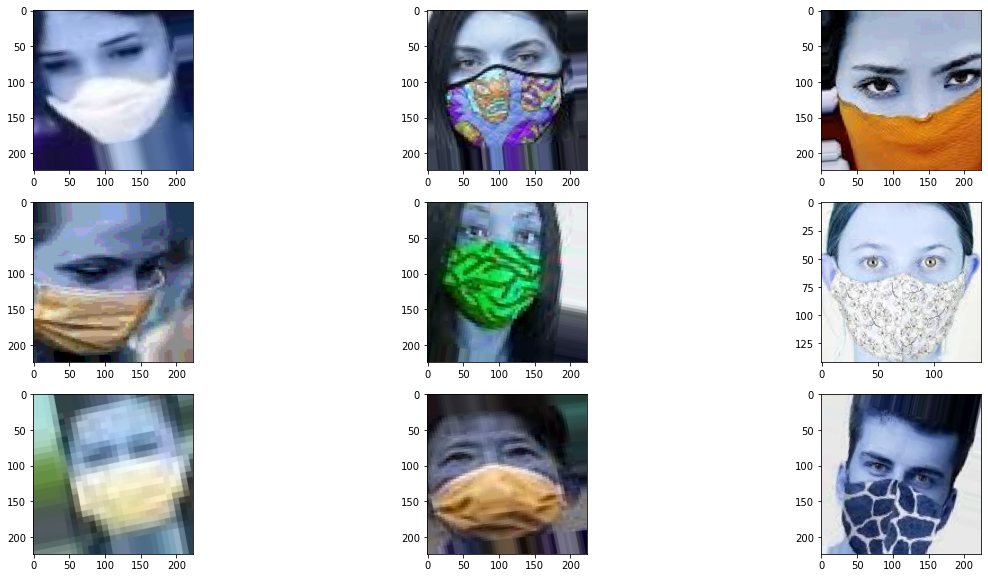

In [137]:
# sample images of people wearing masks
view(mask_path)

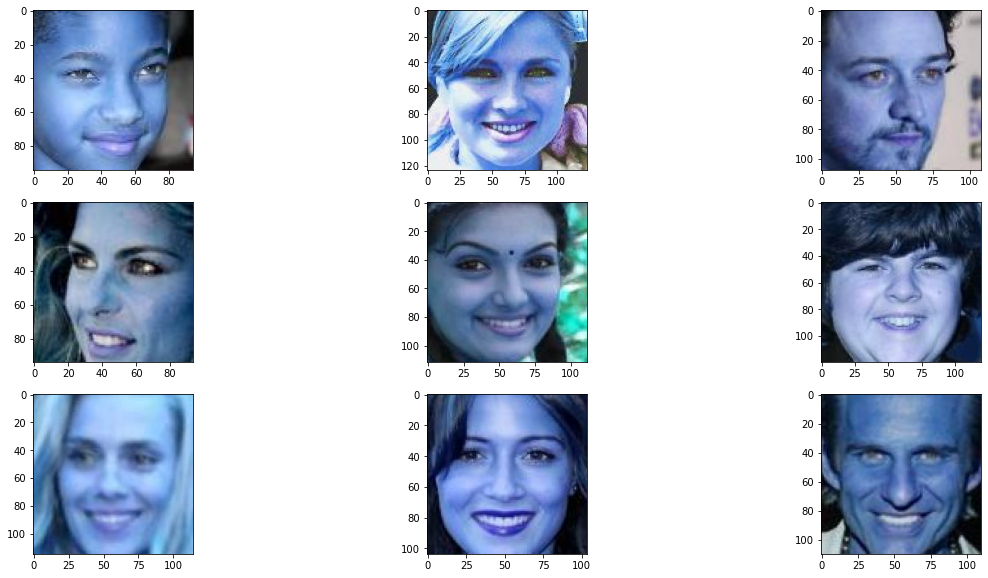

In [138]:
#sample images of people NOT wearning masks
view(nomask_path)

In [139]:
batch_size = 128 # Batch Size
epochs = 15  # Number of Epochs
img_size = 224

In [140]:

# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)
# test_datagen = ImageDataGenerator(rescale=1./255)

# training_set = train_datagen.flow_from_directory(
#         'train',
#         target_size=(224,224),
#         batch_size=16 ,
#         class_mode='binary')

# test_set = test_datagen.flow_from_directory(
#         'test',
#         target_size=(224,224),
#         batch_size=16,
#         class_mode='binary')
# Data Augmentation to increase training dataset size 

train_datagen = ImageDataGenerator(
        rescale=1./255,
#         rotation_range=20,
#         shear_range=0.2,
#         zoom_range=0.2,
#         width_shift_range=0.2,
# 	      height_shift_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)


training_set = train_datagen.flow_from_directory(
        train_path,
        target_size=(img_size,img_size),
        batch_size=batch_size,
        class_mode='binary')


test_set = test_datagen.flow_from_directory(
        test_path,
        target_size=(img_size,img_size),
        batch_size=batch_size,
        class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [141]:

model=Sequential()

model.add(Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l1_l2(0.005)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(2,2))
          
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D(2,2)) 
model.add(Dropout(0.3))

model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2,2)) 

model.add(Flatten())
model.add(Dropout(0.3))
          
model.add(Dense(256, activation ='relu'))
model.add(Dense(128, activation ='relu'))
model.add(Dense(1, activation ='sigmoid'))         

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 26, 26, 128)      

In [142]:

# Optimization of the model is done via Adam optimizer
# Loss is measures in the form of Binary Categorical Cross Entropy as our output contains 2 classes, with_mask and without_mask

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [143]:
history=model.fit(training_set, epochs=epochs, validation_data=test_set)


Epoch 1/15
79/79 [==============================] - 39s 488ms/step - loss: 0.5651 - accuracy: 0.9026 - val_loss: 0.3583 - val_accuracy: 0.9667
Epoch 2/15
79/79 [==============================] - 37s 465ms/step - loss: 0.3338 - accuracy: 0.9657 - val_loss: 0.3006 - val_accuracy: 0.9778
Epoch 3/15
79/79 [==============================] - 37s 469ms/step - loss: 0.2930 - accuracy: 0.9737 - val_loss: 0.2929 - val_accuracy: 0.9738
Epoch 4/15
79/79 [==============================] - 37s 470ms/step - loss: 0.2532 - accuracy: 0.9826 - val_loss: 0.2342 - val_accuracy: 0.9829
Epoch 5/15
79/79 [==============================] - 37s 470ms/step - loss: 0.2220 - accuracy: 0.9856 - val_loss: 0.2332 - val_accuracy: 0.9819
Epoch 6/15
79/79 [==============================] - 38s 482ms/step - loss: 0.2021 - accuracy: 0.9861 - val_loss: 0.2190 - val_accuracy: 0.9788
Epoch 7/15
79/79 [==============================] - 38s 478ms/step - loss: 0.1752 - accuracy: 0.9899 - val_loss: 0.1717 - val_accuracy: 0.9859

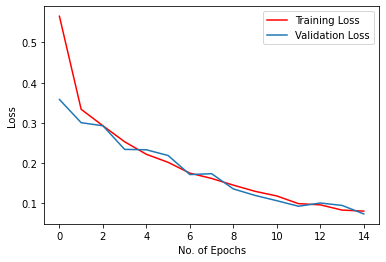

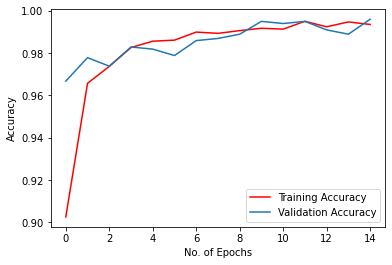

In [144]:
plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy on validation set w.r.t the number of epochs
plt.plot(history.history['accuracy'],'r',label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [145]:
model.save('cnn_(2)_model.h5', history)


In [146]:
# import os
# import sys

# import numpy as np
# # import matplotlib.pyplot as plt
# # %matplotlib inline

# import keras
# from keras.models import load_model
# from keras.models import model_from_json


# import cv2
# import datetime
# # Importing the saved model from the IPython notebook
# mymodel=load_model('../input/img-vid/data_model.h5')

# # Importing the Face Classifier XML file containing all features of the face
# face_classifier=cv2.CascadeClassifier('../input/img-vid/haarcascade_frontalface_default.xml')

# filename = 'video1.avi'
# frames_per_second = 24.0
# res = '480p'
 
# # Set resolution for the video capture
# # Function adapted from https://kirr.co/0l6qmh
# def change_res(cap, width, height):
#     cap.set(3, width)
#     cap.set(4, height)

# # Standard Video Dimensions Sizes
# STD_DIMENSIONS =  {
#     "480p": (640, 480),
#     "720p": (1280, 720),
#     "1080p": (1920, 1080),
#     "4k": (3840, 2160),
# }


# # grab resolution dimensions and set video capture to it.
# def get_dims(cap, res='720p'):
#     width, height = STD_DIMENSIONS["480p"]
#     if res in STD_DIMENSIONS:
#         width,height = STD_DIMENSIONS[res]
#     ## change the current caputre device
#     ## to the resulting resolution
#     change_res(cap, width, height)
#     return width, height

# # Video Encoding, might require additional installs
# # Types of Codes: http://www.fourcc.org/codecs.php
# VIDEO_TYPE = {
#     'avi': cv2.VideoWriter_fourcc(*'XVID'),
#     #'mp4': cv2.VideoWriter_fourcc(*'H264'),
#     'mp4': cv2.VideoWriter_fourcc(*'XVID'),
# }

# def get_video_type(filename):
#     filename, ext = os.path.splitext(filename)
#     if ext in VIDEO_TYPE:
#       return  VIDEO_TYPE[ext]
#     return VIDEO_TYPE['avi']


# # To open a video via link to be inserted in the () of VideoCapture()
# # To open the web cam connected to your laptop/PC, write '0' (without quotes) in the () of VideoCapture()
# cap=cv2.VideoCapture(0)

# out = cv2.VideoWriter(filename, get_video_type(filename), 25, get_dims(cap, res))

# # fourcc = cv2.VideoWriter_fourcc(*'XVID') 
# # out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))

# while cap.isOpened():
#     _,img=cap.read()
#     img=cv2.flip(img,1,1)

#     rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     # detect MultiScale / faces
#     faces = face_classifier.detectMultiScale(rgb, 1.3, 5)
    
#     color_dict={0:(0,255,0),1:(0,0,255)}
#     # Draw rectangles around each face
#     for (x, y, w, h) in faces:

#         #Save just the rectangle faces in SubRecFaces
#         face_img = rgb[y:y+w, x:x+w]

#         face_img=cv2.resize(face_img,(224,224))
#         face_img=face_img/255.0
#         face_img=np.reshape(face_img,(224,224,3))
#         face_img=np.expand_dims(face_img,axis=0)
#         faces = np.vstack([face_img])
#         faces = np.array(faces, dtype="float32")
        
#         pred=mymodel.predict_classes(face_img) 
#         _, accuracy=mymodel.predict(face_img)[0]
# #         print(pred)
#         if  pred[0]==0 and accuracy < 0.5:
#             cv2.putText(img,'MASK',(x,y-30),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),2) 
#             cv2.putText(img,f'Accuracy (%): {(1-accuracy)*100:.2f}',(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),2)
#             cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2) 
#         else:
#             cv2.putText(img,'NO MASK',(x,y-30),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),2)
#             cv2.putText(img,f'Accuracy (%): {accuracy*100:.2f}',(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),2)
#             cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2) 
            
#         datet=str(datetime.datetime.now())
#         cv2.putText(img,datet,(400,450),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),1)

    
#     out.write(img)
    
#     # Show the image
#     cv2.imshow('LIVE DETECTION',img)
    
#     # if key 'q' is press then break out of the loop
#     if cv2.waitKey(1)==ord('q'):
#         break
    
# # Stop video
# cap.release()

# out.release()

# # Close all started windows
# cv2.destroyAllWindows()